# Realtime Weather Information Visualization using MetPy's Simplified Plotting Interface

An important aspect of meteorology and the study of the weather is its near constant impact on our lives, which necessitates access to a wide array of data and products on a realtime basis. This drives the development of tools that simplify and facilitate the ability to readily work with this information. This session uses a Python-based library, MetPy, to work with realtime satellite data and severe weather forecast products to build a visualization of the current weather using MetPy's so-called "simplified plotting interface".

This approach allows us to synthesis multiple types of information together to understand aspects of the current state of the weather.

## Accessing Data: SPC Outlook

The National Weather Service's (NWS) Storm Prediction Center (SPC) regularly produces forecast outlooks that highlight the potential for various severe weather hazards (hail, wind, and tornadoes). The products denote regions across the continental United States (CONUS) with areas denoted as having a general risk of thunderstorms, or having a marginal, slight, enhanced, moderate, or high risk of severe weather.

We can access these data directly from the SPC in geojson format, which gives us the outlook in a format that is readily accessible from Python

In [ ]:
from datetime import datetime

import geopandas

# Set the desired full date and time
dt = datetime(2023, 7, 26, 16, 30)

# Set up a URL to the outlook for the date and time for that product
outlook_url = f'https://www.spc.noaa.gov/products/outlook/archive/{dt:%Y}/day1otlk_{dt:%Y%m%d_%H%M}_cat.lyr.geojson'

# Use geopandas to download and parse the product
day1_outlook = geopandas.read_file(outlook_url)

So what did that get us?

In [ ]:
day1_outlook

## Plotting Data: SPC Outlook

Now that we have the data, let's visualize it on a map! We'll use MetPy to plot this data, which features what it calls its "Simplified Plotting Interface". This interface uses what's refered to as a "declarative" style, setting information about what's desired before asking the library to generate the plot. This is in contrast to the more common "imperative" approach where the user step-by-step tells the computer what should be done. All of this in MetPy is powered by the commonly-used `matplotlib` Python plotting toolkit.

For this style of data that is really just a set of polygons, we can use MetPy's `PlotGeometry`, which is designed for this particular use case.

In [ ]:
from metpy.plots import ImagePlot, MapPanel, PanelContainer, PlotGeometry

# Start by setting up the geometry plot. This makes use of styling information contained in the SPC geojson file
outlook_plot = PlotGeometry()
outlook_plot.geometry = day1_outlook['geometry']
outlook_plot.fill = day1_outlook['fill']
outlook_plot.stroke = day1_outlook['stroke']
outlook_plot.labels = day1_outlook['LABEL']
outlook_plot.label_fontsize = 'medium'

# Create a MapPanel, which is the map on which the plot(s) will be added.
# Here, we can add some map features, a title, and control the projection and bounds.
panel = MapPanel()
panel.title = f'SPC Day 1 Convective Outlook (Valid {dt:%Hz %b %d %Y})'
panel.plots = [outlook_plot]
panel.area = [-120, -75, 25, 50]
panel.projection = 'lcc'
panel.layers = ['land', 'ocean', 'coastline', 'borders', 'states']

# Add this panel to the final plot and ask it to make the image
pc = PanelContainer()
pc.size = (14, 9)
pc.panels = [panel]
pc.show()

### Exercise: Examine another forecast

Following what was done above, can you plot the forecast for **March 31st, 2023**? What kind of risk was present that day?

Bonus points:
* Zoom the plot into an area of interest.
    * Check out the [MetPy Docs](https://unidata.github.io/MetPy/latest/api/generated/metpy.plots.MapPanel.html#metpy.plots.MapPanel.area) for more info
* Add additional map features like lakes.
* Can you remove the fill color (e.g. use `['none']`) for the outlook regions

## Accessing Data: Satellite Data

Satellite data is frequently used for realtime monitoring of weather information due to its ability to collection large amounts of data simultanously across a large area; geostationary satellites are especially useful since they provide constant surveillance centered over the same location on the earth. The data from the operational GOES satellite family are freely available and relatively easy to access from Python, at least for more modern data that is stored in netCDF. For the current generation of satellites, these images are available every 5 minutes over the CONUS.

For realtime access to recent GOES satellite products, we'll turn to the THREDDS Data Server, which provides hosting of a variety of data formats in a web-accessible fashion, through a variety of protocols (e.g. WMS, OPeNDAP, HTTP download). To start, we can take a look at the data [hosted on Unidata's THREDDS server](https://thredds.ucar.edu/thredds/catalog/catalog.html).

For this demonstration, let's look at the data under "Satellite Data"->"GOES East Products"->"CloudAndMoistureImagery". Within this collection, we see things are arranged hierarchically by the image region ("CONUS", "FullDisk", "Mesoscale-1", "Mesoscale-2", "PuertoRico"), channel (i.e. wavelength), and day of collection:

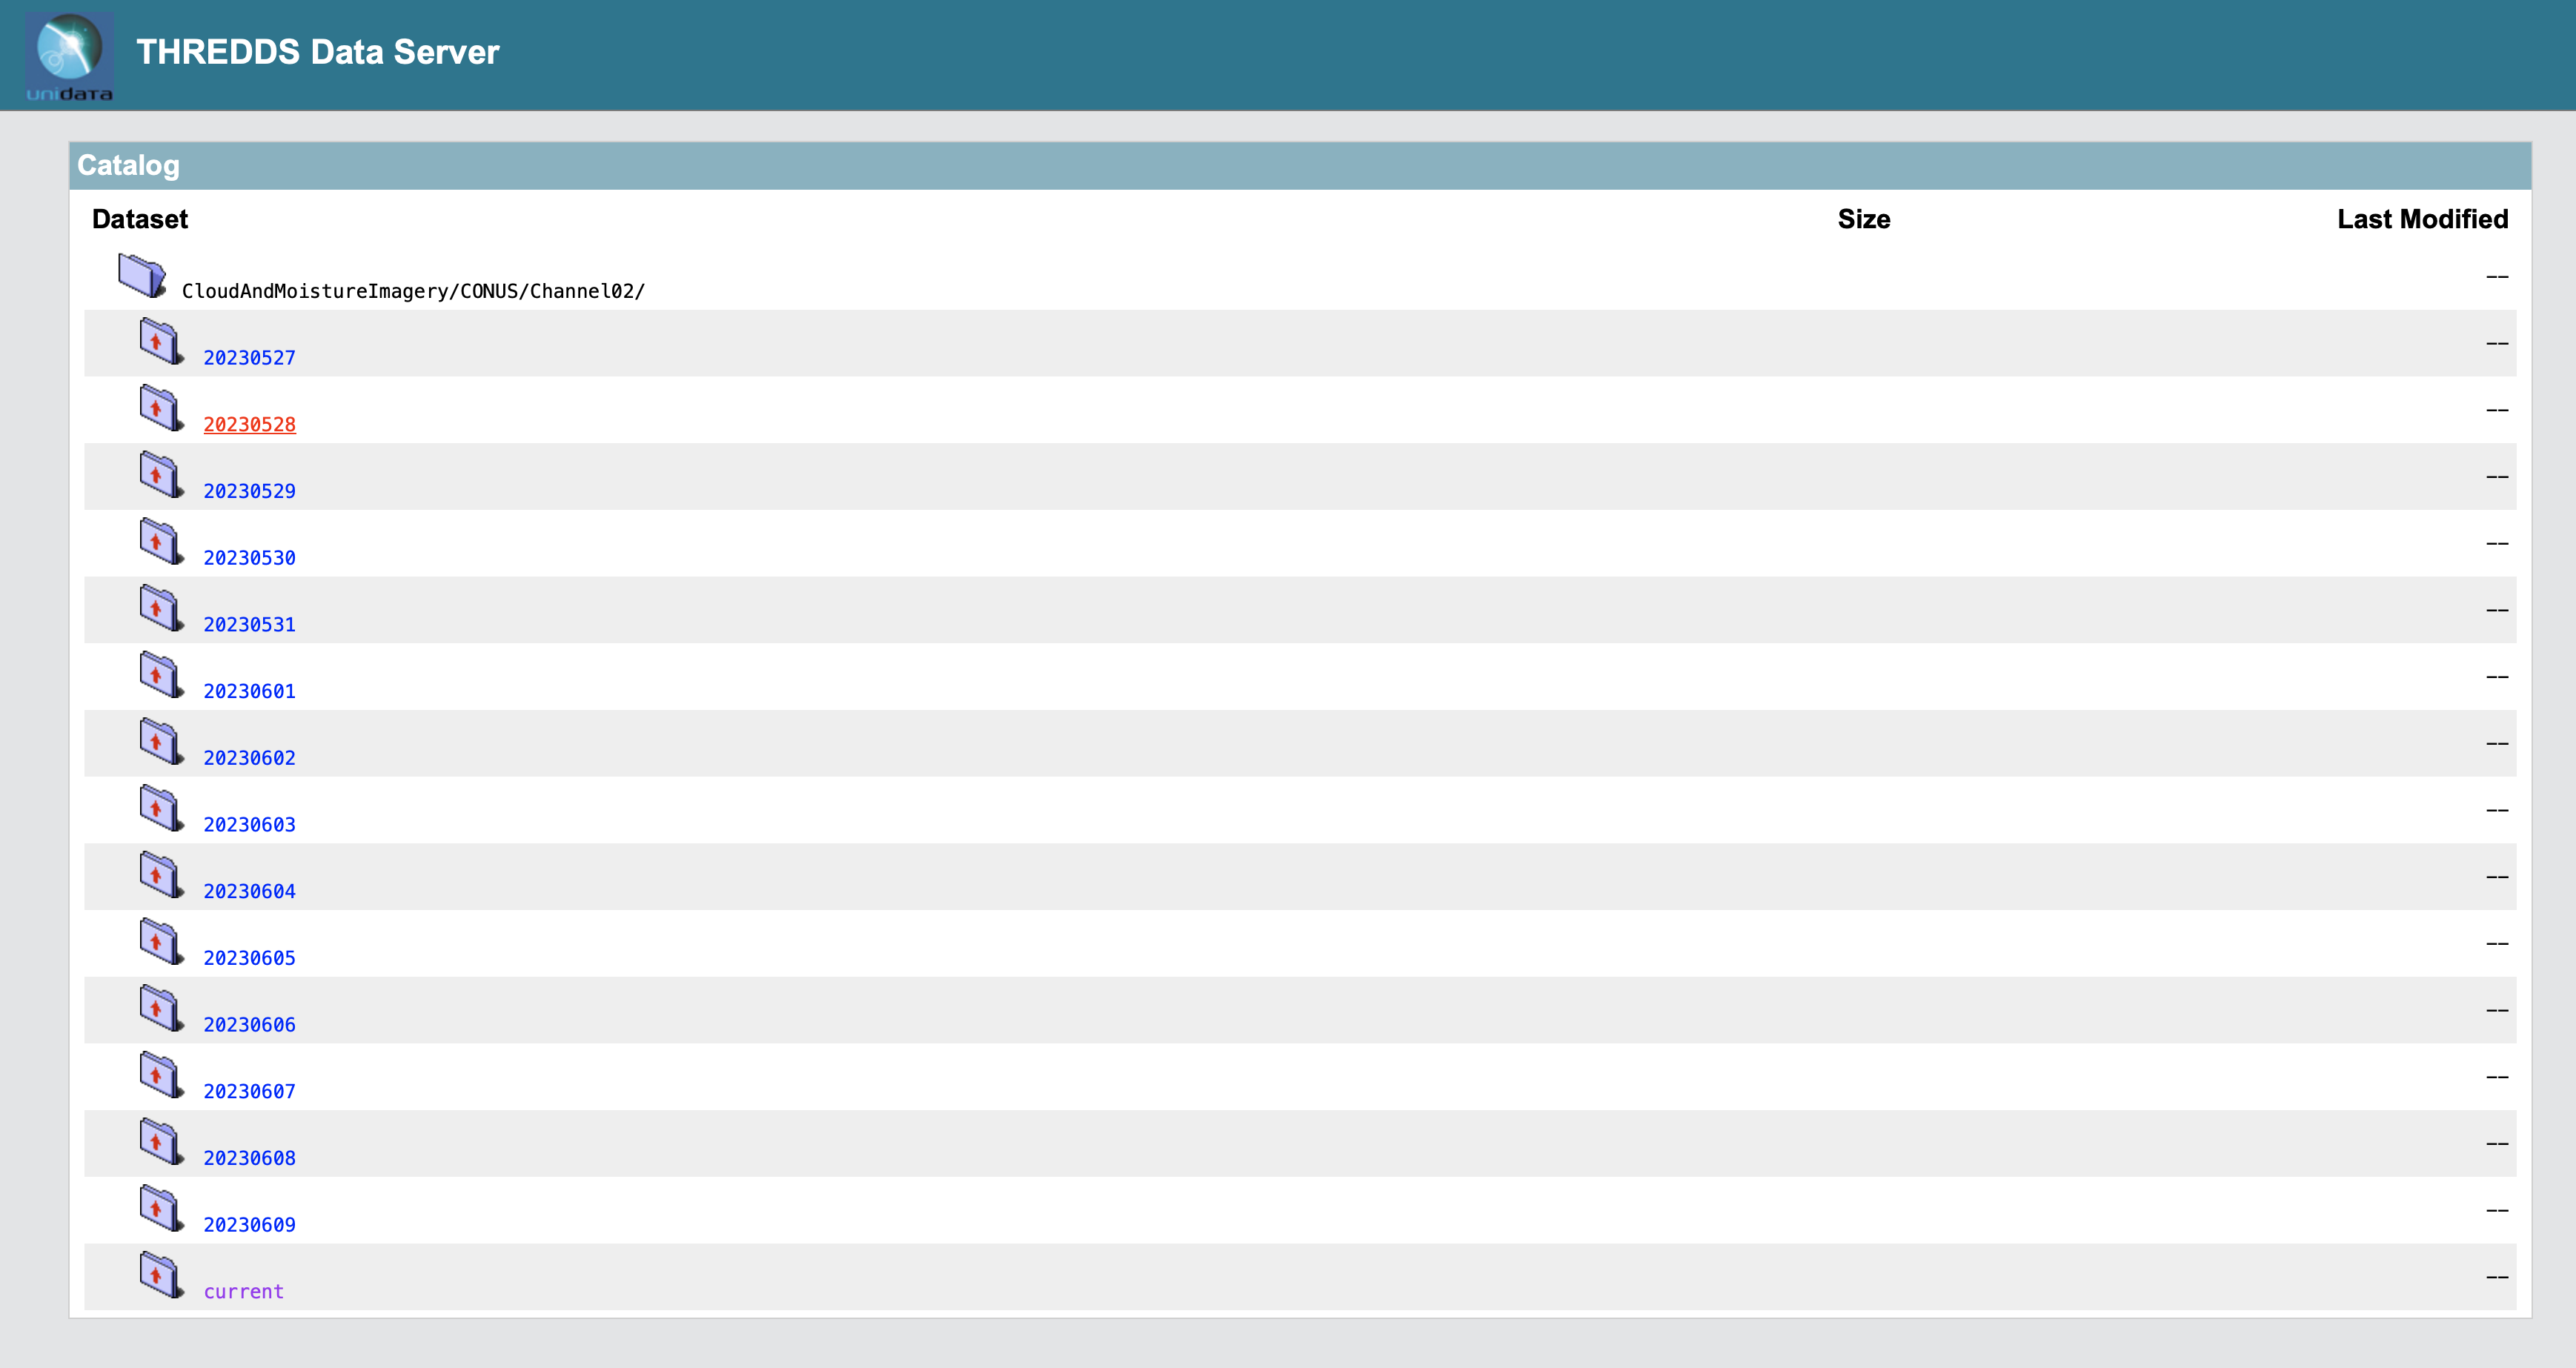

Using the `siphon` library, we can programmatically access the THREDDS server and use it to remotely access a data file.

In [ ]:
from siphon.catalog import TDSCatalog

# Start by pointing at the catalog for the Channel 2 ("visible") data for CONUS on our day of interest
sector = 'CONUS'
channel = 2
cat = TDSCatalog(
    f'https://thredds.ucar.edu/thredds/catalog/satellite/goes/east/products/CloudAndMoistureImagery/'
    f'{sector}/Channel{channel:02d}/{dt:%Y%m%d}/catalog.xml')

We can use Siphon to filter out data from the vast catalog, trying to find the image that matches our desired time. To do this, we tell siphon to look for a certain pattern in the dataset names that should be interpreted as a timestamp, as well as how to parse it:

In [ ]:
ds = cat.datasets.filter_time_nearest(dt, regex=r'_s(?P<strptime>\d{13})', strptime='%Y%j%H%M%S')

Once we have identified our desired dataset, we can set up remote access to the data using xarray:

In [ ]:
sat_data = ds.remote_access(use_xarray=True)

What does the result look like?

In [ ]:
sat_data

## Plotting Data: Satellite Data

Satellite data are usually stored as georeferenced raster arrays, which are readily turned into images. Again, we turn to MetPy for plotting, this time relying on `ImagePlot`.

In [ ]:
from metpy.plots import ImagePlot, MapPanel, PanelContainer

# Create an ImagePlot that points to our accessed data file and the name of the field we want.
image_plot = ImagePlot()
image_plot.data = sat_data
image_plot.field = 'Sectorized_CMI'

# Set a basic greyscale colormap
image_plot.colormap = 'Greys_r'

# Again, add maps, set a projection and bounds
panel = MapPanel()
panel.title = f'{sat_data.satellite_id} Channel {sat_data.channel_id} Imagery'
panel.plots = [image_plot]
panel.area = [-120, -75, 25, 50]
panel.projection = 'lcc'
panel.layers = ['land', 'ocean', 'states', 'coastline', 'borders']

pc = PanelContainer()
pc.size = (14, 9)
pc.panels = [panel]
pc.show()

### Exercise: Fun with satellite data

Try accessing some other satellite data and seeing how the plot changes:
* Pick a different sector/channel
    * Data: https://thredds.ucar.edu/thredds/catalog/satellite/goes/east/products/CloudAndMoistureImagery/CONUS/catalog.html
    * Channel descriptions: https://www.star.nesdis.noaa.gov/GOES/conus.php?sat=G16
* Use a different colormap
    * Options & overview: https://matplotlib.org/stable/tutorials/colors/colormaps.html#classes-of-colormaps

## Plotting Data: Synthesizing multiple data sets together

Combining multiple datasets together allows us to draw more insights than either by itself. For instance, we can observe the hazard forecast today together with a satellite image to see how things are progressing in regions of interest:

In [ ]:
from metpy.plots import ImagePlot, MapPanel, PanelContainer, PlotGeometry

# Plot the SPC outlook -- Same as above, but this time we avoid filling in the outlook regions so we can see the satellite image
outlook_plot = PlotGeometry()
outlook_plot.geometry = day1_outlook['geometry']
outlook_plot.fill = ['none']
outlook_plot.stroke = day1_outlook['stroke']
outlook_plot.labels = day1_outlook['LABEL']
outlook_plot.label_fontsize = 'medium'

# Plot the satellite image
image_plot = ImagePlot()
image_plot.data = sat_data
image_plot.field = 'Sectorized_CMI'
image_plot.colormap = 'Greys_r'

# Set up map
panel = MapPanel()
panel.title = f'SPC Day 1 Convective Outlook (Valid {dt:%Hz %b %d %Y})'
panel.plots = [image_plot, outlook_plot]
panel.area = [-120, -75, 25, 50]
panel.projection = 'lcc'
panel.layers = ['land', 'ocean', 'states', 'coastline', 'borders']

# Create full figure
pc = PanelContainer()
pc.size = (14, 9)
pc.panels = [panel]
pc.show()

## Extra: Add SPC storm reports as well

SPC also provides a summary of reports of severe weather that can be plotted on the map. This is slightly more complicated, as we need to merge multiple data files.

In [ ]:
import numpy as np
import pandas as pd
from shapely.geometry import MultiPoint

url = f'https://www.spc.noaa.gov/climo/reports/{dt:%y%m%d}_rpts_raw_{{kind}}.csv'
reports = [MultiPoint(np.array(pd.read_csv(url.format(kind=kind), skiprows=1)[['LON', 'LAT']]))
           for kind in ('torn', 'hail', 'wind')]

In [ ]:
from metpy.plots import ImagePlot, MapPanel, PanelContainer, PlotGeometry

# Plot the SPC outlook -- Same as above, but this time we avoid filling in the outlook regions so we can see the satellite image
outlook_plot = PlotGeometry()
outlook_plot.geometry = day1_outlook['geometry']
outlook_plot.fill = ['none']
outlook_plot.stroke = day1_outlook['stroke']
outlook_plot.labels = day1_outlook['LABEL']
outlook_plot.label_fontsize = 'medium'

# Plot the reports as points using PlotGeometry. Style maps typical SPC map.
report_plot = PlotGeometry()
report_plot.geometry = reports
report_plot.fill = ['red', 'green', 'blue']
report_plot.marker = '.'

# Plot the satellite image
image_plot = ImagePlot()
image_plot.data = sat_data
image_plot.field = 'Sectorized_CMI'
image_plot.colormap = 'Greys_r'

# Set up map
panel = MapPanel()
panel.title = f'SPC Day 1 Convective Outlook (Valid {dt:%Hz %b %d %Y})'
panel.plots = [image_plot, outlook_plot, report_plot]
panel.area = [-120, -75, 25, 50]
panel.projection = 'lcc'
panel.layers = ['land', 'ocean', 'states', 'coastline', 'borders']

# Create full figure
pc = PanelContainer()
pc.size = (14, 9)
pc.panels = [panel]
pc.show()